# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ConflictPredictionMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [2]:
files = [('green_tripdata_2024-03.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2024-03.parquet: 100%|██████████| 1372372/1372372 [00:13<00:00, 100000.84it/s, save to ./data/green_tripdata_2024-03.parquet]


In [3]:
mar_data = pd.read_parquet('data/green_tripdata_2024-03.parquet')

In [4]:
mar_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,57457.000000,57457,57457,55360.000000,57457.000000,57457.000000,55360.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,57457.000000,0.0,57457.000000,57457.000000,55360.000000,55353.000000,55360.000000
mean,1.877334,2024-03-16 04:02:52.405399,2024-03-16 04:21:00.076039,1.179986,95.524688,138.629149,1.309538,13.522828,17.313474,0.904472,0.577410,2.386255,0.192537,NaN,0.979378,22.904832,1.321062,1.038047,0.737730
min,1.000000,2008-12-31 23:02:24,2008-12-31 23:02:30,1.000000,1.000000,1.000000,0.000000,0.000000,-295.080000,-2.500000,-0.500000,-1.560000,0.000000,NaN,-1.000000,-296.080000,1.000000,1.000000,-2.750000
25%,2.000000,2024-03-08 13:53:56,2024-03-08 14:13:49,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,13.440000,1.000000,1.000000,0.000000
50%,2.000000,2024-03-15 22:49:01,2024-03-15 23:09:52,1.000000,75.000000,138.000000,1.000000,1.790000,13.500000,0.000000,0.500000,2.000000,0.000000,NaN,1.000000,18.500000,1.000000,1.000000,0.000000
75%,2.000000,2024-03-23 20:11:25,2024-03-23 20:34:48,1.000000,97.000000,220.000000,1.000000,3.100000,19.800000,1.000000,0.500000,3.610000,0.000000,NaN,1.000000,27.050000,2.000000,1.000000,2.750000
max,2.000000,2024-04-01 00:01:45,2024-04-01 16:11:00,99.000000,265.000000,265.000000,9.000000,125112.200000,841.600000,10.000000,4.250000,150.000000,26.760000,NaN,1.000000,856.980000,5.000000,2.000000,2.750000
std,0.328056,NaN,NaN,1.356719,57.285088,76.295346,0.967749,770.416255,14.958249,1.382446,0.366916,3.159273,1.184551,NaN,0.154253,17.013735,0.497858,0.191311,1.218039


In [5]:
mar_data.shape

(57457, 20)

In [6]:
# create target
mar_data["duration_min"] = mar_data.lpep_dropoff_datetime - mar_data.lpep_pickup_datetime
mar_data.duration_min = mar_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [7]:
# filter out outliers
mar_data = mar_data[(mar_data.duration_min >= 0) & (mar_data.duration_min <= 60)]
mar_data = mar_data[(mar_data.passenger_count > 0) & (mar_data.passenger_count <= 8)]

<Axes: >

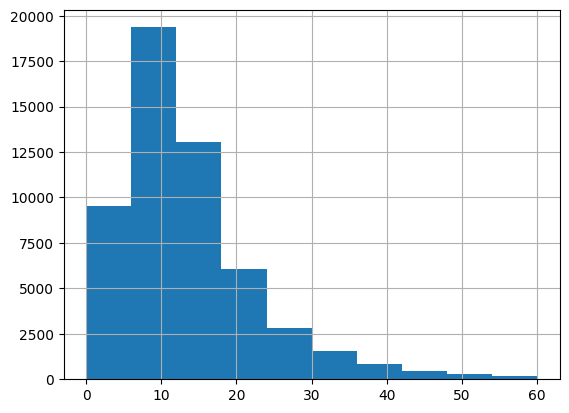

In [8]:
mar_data.duration_min.hist()

In [9]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [10]:
mar_data.shape

(54135, 21)

In [11]:
train_data = mar_data[:30000]
val_data = mar_data[30000:]

In [12]:
model = LinearRegression()

In [13]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [14]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [15]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [16]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.772473239359444
3.716814567929365


# Dump model and reference data

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [18]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [19]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [20]:
train_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration_min,prediction
0,2,2024-03-01 00:10:52,2024-03-01 00:26:12,N,1.0,129,226,1.0,1.72,12.8,...,3.06,0.0,NaN,1.0,18.36,1.0,1.0,0.00,15.333333,11.306020
1,2,2024-03-01 00:22:21,2024-03-01 00:35:15,N,1.0,130,218,1.0,3.25,17.7,...,0.00,0.0,NaN,1.0,20.20,2.0,1.0,0.00,12.900000,14.909065
2,2,2024-03-01 00:45:27,2024-03-01 01:04:32,N,1.0,255,107,2.0,4.58,23.3,...,3.50,0.0,NaN,1.0,32.05,1.0,1.0,2.75,19.083333,17.210496
3,1,2024-03-01 00:02:00,2024-03-01 00:23:45,N,1.0,181,71,1.0,0.00,22.5,...,0.00,0.0,NaN,1.0,24.00,1.0,1.0,0.00,21.750000,11.980403
4,2,2024-03-01 00:16:45,2024-03-01 00:23:25,N,1.0,95,135,1.0,1.15,8.6,...,1.00,0.0,NaN,1.0,12.10,1.0,1.0,0.00,6.666667,9.062905


In [21]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ConflictPredictionMetric(),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
]
)

In [22]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [ ]:
# report.show(mode='inline')

In [23]:
result = report.as_dict()

In [ ]:
result

In [24]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.01006459378009672

In [25]:
#number of drifted columns
result['metrics'][1]['result']['number_of_drifted_columns']

0

In [26]:
#share of missing values
result['metrics'][2]['result']['current']['share_of_missing_values']

0.045458312145695616

In [27]:
#number of not stable predictions
result['metrics'][3]['result']['current']['number_not_stable_prediction']

0

In [28]:
#0.5 quantile of fare_amount
result['metrics'][4]['result']['current']['value']

13.5

# Evidently Dashboard

In [29]:
from evidently.metric_preset import DataDriftPreset, DataQualityPreset

from evidently.ui.workspace import Workspace
from evidently.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter
from evidently.renderers.html_widgets import WidgetSize

In [30]:
ws = Workspace("workspace")

In [31]:
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

Project(id=UUID('1cfae92e-da76-41fa-97fa-c1dfaa57d033'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[], tabs=[], tab_id_to_panel_ids={}), team_id=None, date_from=None, date_to=None, created_at=datetime.datetime(2024, 6, 28, 13, 38, 3, 667025))

In [ ]:
regular_report = Report(
    metrics=[
        DataQualityPreset(),
        ConflictPredictionMetric(),
        ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
        
    ],
    timestamp=datetime.datetime(2024,3,23)
)

regular_report.run(reference_data=None,
                  current_data=val_data.loc[val_data.lpep_pickup_datetime.between('2024-03-23', '2024-03-24', inclusive="left")],
                  column_mapping=column_mapping)

# regular_report

In [ ]:
ws.add_report(project.id, regular_report)

In [32]:
#configure the dashboard
project.dashboard.add_panel(
    DashboardPanelCounter(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        agg=CounterAgg.NONE,
        title="NYC taxi data dashboard"
    )
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Prediction Conflicts",
        values=[
            PanelValue(
                metric_id="ConflictPredictionMetric",
                field_path="current.number_not_stable_prediction",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)

project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Fare amount 0.5 quantile",
        values=[
            PanelValue(
                metric_id="ColumnQuantileMetric",
                field_path="current.value",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    ),
)


project.save()

Project(id=UUID('1cfae92e-da76-41fa-97fa-c1dfaa57d033'), name='NYC Taxi Data Quality Project', description='My project description', dashboard=DashboardConfig(name='NYC Taxi Data Quality Project', panels=[DashboardPanelCounter(type='evidently.ui.dashboards.reports.DashboardPanelCounter', id=UUID('e1eb2f31-df9b-4b64-be9a-c4764e993d01'), title='NYC taxi data dashboard', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.FULL: 2>, agg=<CounterAgg.NONE: 'none'>, value=None, text=None), DashboardPanelPlot(type='evidently.ui.dashboards.reports.DashboardPanelPlot', id=UUID('b14a23d8-5cb2-4c97-876e-89f2527a21c1'), title='Inference Count', filter=ReportFilter(metadata_values={}, tag_values=[], include_test_suites=False), size=<WidgetSize.HALF: 1>, values=[PanelValue(field_path='current.number_of_rows', metric_id='DatasetSummaryMetric', metric_fingerprint=None, metric_args={}, legend='count')], plot_type=<PlotType.BAR: 'bar'>), DashboardPanelPlot(

In [33]:
model = load('models/lin_reg.bin')

In [34]:
predictions = model.predict(mar_data[num_features + cat_features])

In [35]:
mar_data['prediction'] = predictions

In [39]:
import datetime
import pandas as pd

# Assuming 'mar_data', 'column_mapping', 'ws', and 'project.id' are already defined

start_date = datetime.datetime(2024, 3, 1)
end_date = datetime.datetime(2024, 3, 31)

current_date = start_date
while current_date <= end_date:
    next_day = current_date + datetime.timedelta(days=1)
    
    regular_report = Report(
        metrics=[
            DataQualityPreset(),
            ConflictPredictionMetric(),
            ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
        ],
        timestamp=current_date
    )
    
    regular_report.run(
        reference_data=None,
        current_data=mar_data.loc[mar_data.lpep_pickup_datetime.between(current_date.strftime('%Y-%m-%d'), next_day.strftime('%Y-%m-%d'), inclusive="left")],
        column_mapping=column_mapping
    )
    
    ws.add_report(project.id, regular_report)
    
    current_date = next_day

/home/yorgos/mlops-zoomcamp/.venv/lib/python3.9/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/yorgos/mlops-zoomcamp/.venv/lib/python3.9/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/yorgos/mlops-zoomcamp/.venv/lib/python3.9/site-packages/evidently/metrics/data_integrity/column_summary_metric.py:185: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  curr_data = current_data.dt.to_period(freq=freq).value_counts().reset_index()
/home/yorgos/mlops-zoomcamp/.venv/lib/python3.9/site-packages/evidently/metrics/data_integr